# Importing Libraries

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf

from pathlib import Path
from sklearn.model_selection import train_test_split

import cv2 
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Dataset Distribution

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19880\2020735786.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette="viridis")


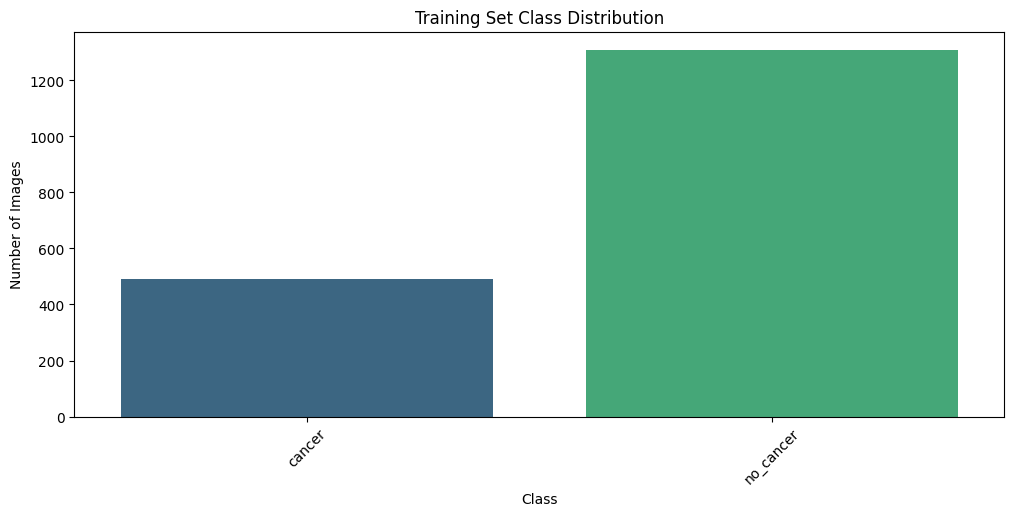

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define dataset paths
train_dir = r'E:\Priya Final\lung_cancer_MRI_dataset\train'
val_dir = r'E:\Priya Final\lung_cancer_MRI_dataset\validate'

# Get class distribution
def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Plot class distribution
train_distribution = get_class_distribution(train_dir)
test_distribution = get_class_distribution(val_dir)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette="viridis")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
image_size = (224, 224)
batch_size = 32
SEED = 42 

# Data Augmentation and Preprocessing for training
train_datagen =  ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

# Pass both the raw generator AND the ImageDataGenerator to your custom generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode='grayscale',
    seed=SEED,
    shuffle=True
)

# Validation data is kept consistent (only rescaling) to reflect real-world conditions
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Apply generator to validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,              
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary",
    color_mode='grayscale',
    shuffle=False,  
    seed=SEED
)

# Print class labels for verification
print("Class Labels:", train_generator.class_indices)

Found 1800 images belonging to 2 classes.
Found 1233 images belonging to 2 classes.
Class Labels: {'cancer': 0, 'no_cancer': 1}


# Training Set Class Distribution

C:\Users\ASUS\AppData\Local\Temp\ipykernel_19880\3599288483.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), ax=axes[0], palette="viridis")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19880\3599288483.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(train_distribution.keys(), rotation=45)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_19880\3599288483.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(val_distribution.keys()), y=list(val_distribution.values()), ax=axes[1], palette="magma")
C:\Users\AS

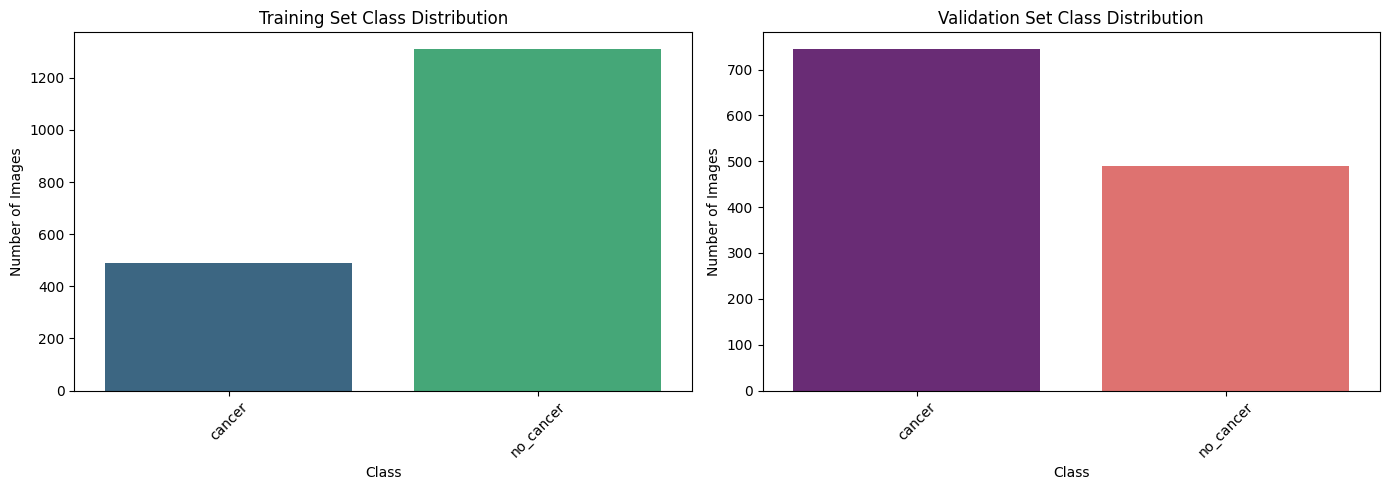

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get class indices from the original generator
train_class_counts = train_generator.class_indices
val_class_counts = val_generator.class_indices

# Access labels from the base generator, not the custom wrapper
train_labels = train_generator.classes
val_labels = val_generator.classes

# Compute distribution
train_distribution = {cls: np.sum(train_labels == idx) for cls, idx in train_class_counts.items()}
val_distribution = {cls: np.sum(val_labels == idx) for cls, idx in val_class_counts.items()}

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), ax=axes[0], palette="viridis")
axes[0].set_title("Training Set Class Distribution")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Number of Images")
axes[0].set_xticklabels(train_distribution.keys(), rotation=45)

sns.barplot(x=list(val_distribution.keys()), y=list(val_distribution.values()), ax=axes[1], palette="magma")
axes[1].set_title("Validation Set Class Distribution")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Number of Images")
axes[1].set_xticklabels(val_distribution.keys(), rotation=45)

plt.tight_layout()
plt.show()


# Building CNN Model

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def build_lung_mri_model(input_shape=(224, 224, 1), num_classes=1):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.3))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

# Initialize the model
input_shape = (224, 224, 1)
num_classes = 1
model = build_lung_mri_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Show model architecture
model.summary()

E:\Priya Final\final\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,849 (495.50 KB)

 Trainable params: 126,401 (493.75 KB)

 Non-trainable params: 448 (1.75 KB)

# Calculating class weight

In [6]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from the training generator
class_indices = train_generator.class_indices
class_labels = list(class_indices.values())

# Get class distribution from the training generator
num_classes = len(class_labels)
class_counts = np.bincount(train_generator.classes)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(class_labels),
    y=train_generator.classes
)

# Convert to dictionary format required by model.fit()
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(1.8329938900203666), 1: np.float64(0.6875477463712758)}


# Model Training

In [7]:
import numpy as np
# Early Stopping Configuration
early_stopping = EarlyStopping(
    monitor='val_loss',      
    patience=10,             
    min_delta=0.001,         
    restore_best_weights=True,  
    verbose=1
)

# Learning Rate Reduction Configuration
model_rlr = ReduceLROnPlateau(
    monitor='val_loss',      
    factor=0.5,              
    patience=5,              
    min_lr=1e-6,             
    cooldown=2,              
    verbose=1
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    epochs=15,
    batch_size=32,
    callbacks=[early_stopping, model_rlr],
    )

model.save('mri_cnn_model.h5')

E:\Priya Final\final\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.5666 - loss: 0.6943 - val_accuracy: 0.6034 - val_loss: 0.6856 - learning_rate: 1.0000e-04
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.5360 - loss: 0.6872 - val_accuracy: 0.6034 - val_loss: 0.6805 - learning_rate: 1.0000e-04
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.5721 - loss: 0.6862 - val_accuracy: 0.6034 - val_loss: 0.6696 - learning_rate: 1.0000e-04
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.5976 - loss: 0.6649 - val_accuracy: 0.6034 - val_loss: 0.6647 - learning_rate: 1.0000e-04
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.6050 - loss: 0.6563 - val_accuracy: 0.6034 - val_loss: 0.6550 - learning_rate: 1.0000e-04
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.6473 - loss: 0.6329 - val_accuracy: 0.6034 - val_loss: 0.6596 - learning_rate: 1.0000e-04
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.5708 

# Visualize Training Process

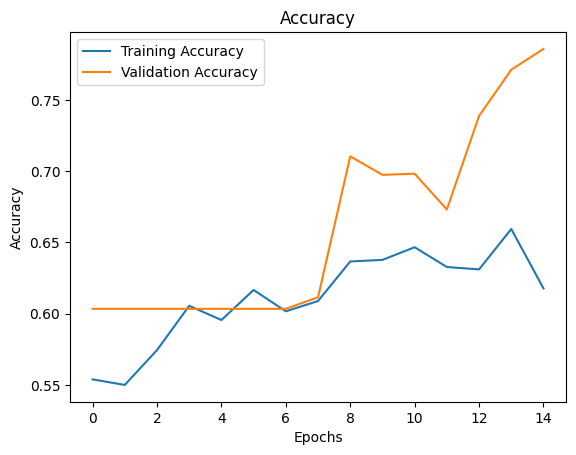

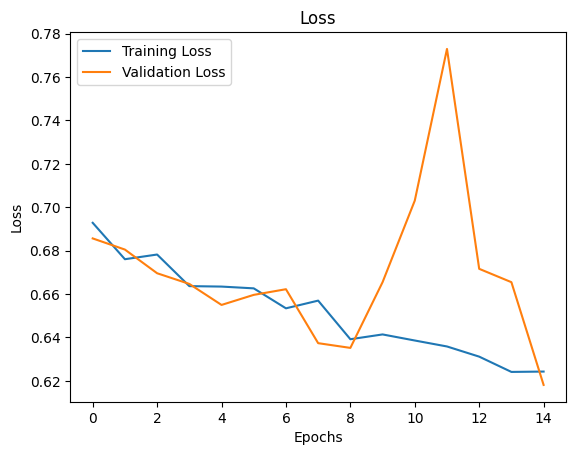

In [8]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

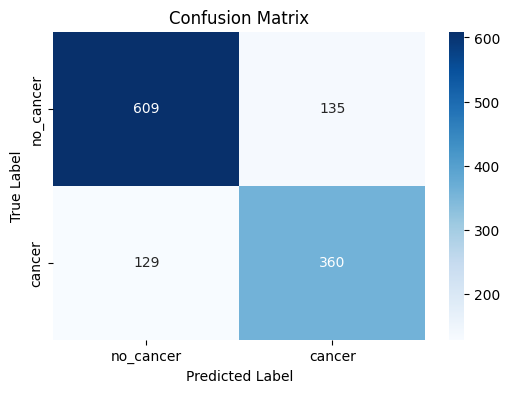

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get all validation data
y_true = []
y_pred = []

for i in range(len(val_generator)):
    x_batch, y_batch = val_generator[i]
    y_true.extend(y_batch.ravel())  # flatten in case it's shape (batch, 1)
    preds = model.predict(x_batch)
    y_pred.extend(preds.ravel())    # flatten predictions

# Convert to binary predictions
y_pred_binary = (np.array(y_pred) > 0.5).astype(int)
y_true = np.array(y_true).astype(int)

# Classification Report
print(classification_report(y_true, y_pred_binary, target_names=['no_cancer', 'cancer']))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['no_cancer', 'cancer'], yticklabels=['no_cancer', 'cancer'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [10]:
model.save("lung_cancer_model.h5")
